# Import important libraries

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random

## 0. Reusable function

In [88]:
def visualize_dataset(dataset, ordNumberOfAssignment: int):
    """
    Visualizes a 2D dataset using a scatter plot.

    Args:
        dataset (numpy.ndarray): A numpy array of shape (n, 2) containing the data points.
    """
    plt.figure(figsize=(8, 6)) 
    plt.scatter(dataset[:, 0], dataset[:, 1], s=10)
    plt.title('Toy Dataset Visualization')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.savefig(f'img/{ordNumberOfAssignment}_unclustered_dataset.png')
    plt.show()

In [89]:
def visualize_clusters(clusters, ordNumberOfAssignment: int):
    """
    Visualizes clusters with their points and centroids.

    Parameters:
        clusters (dict): A dictionary where each key is a cluster ID and the value is a dict
                         with 'centroid' (2-element list) and 'points' (list of 2D arrays).
    """
    plt.figure(figsize=(10, 8))
    
    colors = plt.cm.get_cmap('tab10', len(clusters))  # Get distinct colors

    for idx, (cluster_id, data) in enumerate(clusters.items()):
        points = np.array(data['points'])
        centroid = np.array(data['centroid'])

        plt.scatter(points[:, 0], points[:, 1], s=30, label=f'Cluster {cluster_id}', alpha=0.6, color=colors(idx))
        plt.scatter(centroid[0], centroid[1], c='black', s=100, marker='X', edgecolor='white', linewidth=1.5, label=f'Centroid {cluster_id}')

    plt.title('Cluster Visualization')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'img/{ordNumberOfAssignment}_clustered_dataset.png')
    plt.show()

## 1. Assignment 01

### 1.1. Task 01
Generate a toy dataset having $600$ data points, $200$ points of them following the Gaussian distribution $\mathcal{N}((2, 2), \Sigma)$, $200$ points of them following the Gaussian distribution $\mathcal{N}((8, 3), \Sigma)$, and $200$ points of them following the Gaussian distribution $\mathcal{N}((3, 6), \Sigma)$ where $\Sigma = 
\left(\begin{array}{cc}
    1 & 0 \\
    0 & 1
\end{array}\right)
$.

In [90]:
def generate_dataset():
    """
    Generates a toy dataset with 600 data points from three Gaussian distributions.

    The dataset consists of:
    - 200 points from N((2, 2), Sigma)
    - 200 points from N((8, 3), Sigma)
    - 200 points from N((3, 6), Sigma)
    where Sigma is the 2x2 identity matrix.

    Returns:
        numpy.ndarray: A numpy array of shape (600, 2) containing the generated data points.
    """
    # Define the means for the three Gaussian distributions
    mean1 = np.array([2, 2])
    mean2 = np.array([8, 3])
    mean3 = np.array([3, 6])

    covariance = np.array([[1, 0], [0, 1]])
    num_points_per_cluster = 200

    # Generate data points from the 1st, 2nd, 3rd Gaussian distribution
    data_cluster1 = np.random.multivariate_normal(mean1, covariance, num_points_per_cluster)
    data_cluster2 = np.random.multivariate_normal(mean2, covariance, num_points_per_cluster)
    data_cluster3 = np.random.multivariate_normal(mean3, covariance, num_points_per_cluster)

    # Concatenate the data from the three clusters
    toy_dataset = np.concatenate((data_cluster1, data_cluster2, data_cluster3), axis=0)

    return toy_dataset

In [91]:
dataset1 = generate_dataset()
dataset1

array([[1.42969422, 3.08108733],
       [1.09763993, 1.13534712],
       [1.6918831 , 1.52370763],
       ...,
       [2.81257494, 6.6396986 ],
       [3.49755423, 5.32152399],
       [3.30358133, 6.5103614 ]], shape=(600, 2))

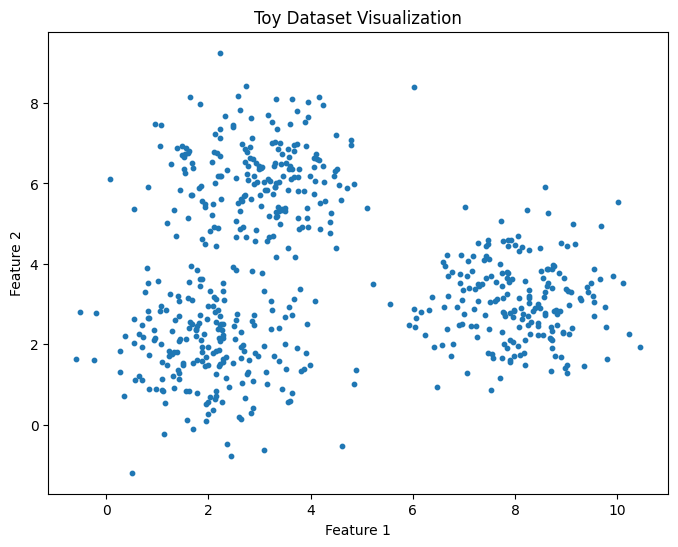

In [92]:
visualize_dataset(dataset=dataset1, ordNumberOfAssignment=1)

### 1.2. Task 02
- Use Numpy only to implement the K-means method for finding three clusters from the toy dataset.
- Train this K-means with EM method.

In [93]:
clustered_dataset1 = {
    0: {'list': [dataset1[0]], 'centroid': dataset1[0]},
    1: {'list': [dataset1[1]], 'centroid': dataset1[1]},
    2: {'list': [dataset1[2]], 'centroid': dataset1[2]},
}
for cluster in clustered_dataset1:
    print(cluster)

0
1
2


In [94]:
def calculate_distance(pointA: list[float], pointB: list[float]) -> float:
    """
    Calculates the Euclidean distance between two points.
    Assumes points are lists of floats of the same dimension.
    """
    if len(pointA) != len(pointB):
        raise ValueError("Points must have the same dimension.")
    squared_diffs = [(a - b)**2 for a, b in zip(pointA, pointB)]
    return sum(squared_diffs)**0.5


calculate_distance([0, 0], [3, 4])

5.0

In [95]:
def find_nearestCluster(_datapoint: list[float], _clusters: dict) -> int:
    """
    Finds the ID of the cluster whose centroid is closest to the given datapoint.
    _clusters is a dictionary where keys are cluster IDs (e.g., 0, 1, 2)
    and values are dictionaries containing 'centroid' (list of floats)
    and 'points' (list of datapoints assigned to it).
    """
    min_distance = float('inf')
    nearest_cluster_id = -1
    for cluster_id, cluster_data in _clusters.items():
        centroid = cluster_data['centroid']
        distance = calculate_distance(_datapoint, centroid)
        if distance < min_distance:
            min_distance = distance
            nearest_cluster_id = cluster_id
    return nearest_cluster_id


In [96]:
def update_latestCentroid(data_list: list[list[float]]) -> list[float]:
    """
    Calculates the new centroid (mean) for a list of data points.
    Assumes all data points in data_list have the same dimension.
    Returns a list of floats representing the new centroid.
    """
    if not data_list:
        # Handle empty cluster, perhaps return None or the previous centroid
        # For K-Means, typically an empty cluster indicates a problem or
        # that the cluster should be removed or reinitialized.
        # For simplicity, we'll return an empty list or raise an error.
        return []
        
    num_dimensions = len(data_list[0])
    new_centroid = [0.0] * num_dimensions
    for datapoint in data_list:
        for i in range(num_dimensions):
            new_centroid[i] += datapoint[i]
    
    num_points = len(data_list)
    return [coord / num_points for coord in new_centroid]

In [97]:
for i, row in enumerate(dataset1, start=0):
    if i < 3:
        continue
    
    index = find_nearestCluster(row, clustered_dataset1)
    clustered_dataset1[index]['list'].append(row)
    clustered_dataset1[index]['centroid'] = update_latestCentroid(clustered_dataset1[index]['list'])

cluster1 = np.array(clustered_dataset1[0]['list'])
cluster2 = np.array(clustered_dataset1[1]['list'])
cluster3 = np.array(clustered_dataset1[2]['list'])

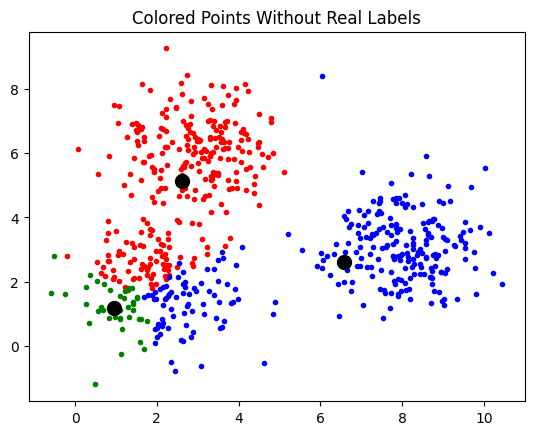

In [98]:
def visualize_assignment1():
    plt.scatter(cluster1[:, 0], 
                cluster1[:, 1], 
                color='red', 
                alpha = 1,
                marker='.'
    )
    plt.scatter(clustered_dataset1[0]['centroid'][0],
            clustered_dataset1[0]['centroid'][1],
            color='black',
            s=100
    )

    plt.scatter(cluster2[:, 0], 
                cluster2[:, 1], 
                color='green', 
                alpha = 1,
                marker='.'
    )
    plt.scatter(clustered_dataset1[1]['centroid'][0],
            clustered_dataset1[1]['centroid'][1],
            color='black',
            s=100
    )

    plt.scatter(cluster3[:, 0], 
                cluster3[:, 1], 
                color='blue', 
                alpha = 1,
                marker='.'
    )
    plt.scatter(clustered_dataset1[2]['centroid'][0],
            clustered_dataset1[2]['centroid'][1],
            color='black',
            s=100
    )
    plt.title("Colored Points Without Real Labels")

    plt.savefig('img/1_clustered_assignment01.png')

visualize_assignment1()

In [99]:
def implement_kMeans_assignment1(dataset: list[list[float]], numberOfClusters: int = 3, max_iterations: int = 100) -> dict:
    '''
    Implements the K-Means clustering algorithm for Assignment 1.

    The algorithm follows these steps:
    1.  **Initialization**: Randomly selects `numberOfClusters` data points from the
        `dataset` as initial centroids.
    2.  **Iterative Process** (until convergence or max_iterations):
        a.  **Assignment Step**: Assigns each data point in the `dataset` to the
            nearest centroid.
        b.  **Update Step**: Recalculates the centroids based on the mean of all
            data points assigned to each cluster.
        c.  **Convergence Check**: Determines if the centroids have moved significantly.
            If not, the algorithm is considered converged.

    Args:
        dataset (list[list[float]]): A list of data points, where each data point
                                     is represented as a list of floats.
        numberOfClusters (int): The desired number of clusters (k). Default is 3.
        max_iterations (int): The maximum number of iterations to run the algorithm.
                              Default is 100.

    Returns:
        dict: A dictionary where keys are cluster IDs (integers, 0 to k-1) and
              values are dictionaries containing:
              - 'centroid': The final centroid of the cluster (list of floats).
              - 'points': A list of data points assigned to that cluster.
    '''

    # Step 1: Initialize centroids randomly
    # Select 'numberOfClusters' unique random data points from the dataset as initial centroids.
    initial_centroid_indices = random.sample(range(len(dataset)), numberOfClusters)
    
    clusters = {}
    for i, idx in enumerate(initial_centroid_indices):
        clusters[i] = {
            'centroid': list(dataset[idx]),  # Make a copy to avoid modifying original dataset point
            'points': []                     # Initially empty, filled in assignment step
        }

    # Iterate until convergence or max_iterations
    for iteration in range(max_iterations):
        # Store old centroids to check for convergence later
        old_centroids = {k: list(v['centroid']) for k, v in clusters.items()} 

        # Step 2a: Assignment Step - Assign each data point to the nearest cluster
        # Create a new structure for the current iteration's assignments
        new_assignments = {i: [] for i in range(numberOfClusters)}
        
        for datapoint in dataset:
            cluster_id = find_nearestCluster(datapoint, clusters)
            new_assignments[cluster_id].append(datapoint)
        
        # Step 2b: Update Step - Recalculate centroids
        converged = True
        for cluster_id, points_in_cluster in new_assignments.items():
            if points_in_cluster:  # Only update if the cluster has points assigned
                new_centroid = update_latestCentroid(points_in_cluster)
                # Check for convergence *while* updating
                if calculate_distance(old_centroids[cluster_id], new_centroid) > 1e-6: # Small threshold for floating point comparison
                    converged = False
                clusters[cluster_id]['centroid'] = new_centroid
            else:
                # If a cluster becomes empty, its centroid won't move based on points.
                # In robust implementations, you might reinitialize such a centroid.
                # For simplicity here, we consider it not converged if it was previously non-empty
                # and now has no new points to update from, implying its position might still be suboptimal.
                # For convergence check, if its centroid hasn't moved from old_centroids, it's fine.
                pass # Keep old centroid if cluster is empty, and it won't affect convergence check if old and new are same.
                
            # Update the points list in the main clusters dictionary for the next iteration/final output
            clusters[cluster_id]['points'] = points_in_cluster

        # Step 2c: Check for convergence
        if converged:
            print(f"K-Means converged after {iteration + 1} iterations.")
            break
    else:
        print(f"K-Means reached maximum iterations ({max_iterations}) without converging.")

    return clusters

K-Means converged after 3 iterations.


C:\Users\VICTUS\AppData\Local\Temp\ipykernel_1740\2954007180.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(clusters))  # Get distinct colors


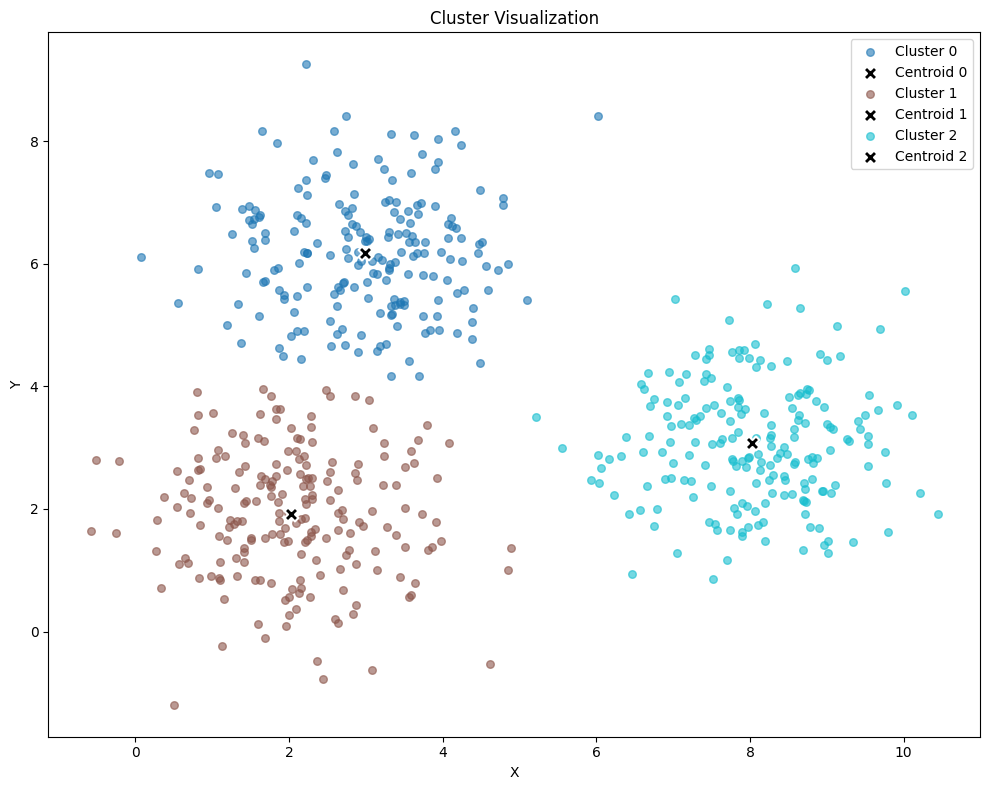

In [100]:
cluster1 = implement_kMeans_assignment1(dataset1)
visualize_clusters(clusters=cluster1, ordNumberOfAssignment=1)

## Assignment 02

### Task 2.1.
- Generate a toy dataset having $50$ points following the Gaussian distribution $\mathcal{N}((2, 2), \Sigma)$, $20$ points of them following the Gaussian distribution $\mathcal{N}((8, 3), \Sigma)$, and $1000$ points of them following the Gaussian distribution $\mathcal{N}((3, 6), \Sigma)$ where $\Sigma = 
\left(\begin{array}{cc}
    1 & 0 \\
    0 & 1
\end{array}\right)
$.

In [101]:
def generate_dataset2():
    """
    Generates a toy dataset with 1070 data points from three Gaussian distributions.

    The dataset consists of:
    - 50 points from N((2, 2), Sigma)
    - 20 points from N((8, 3), Sigma)
    - 1000 points from N((3, 6), Sigma)
    where Sigma is the 2x2 identity matrix.

    Returns:
        numpy.ndarray: A numpy array of shape (1070, 2) containing the generated data points.
    """
    # Define the means for the three Gaussian distributions
    mean1 = np.array([2, 2])
    mean2 = np.array([8, 3])
    mean3 = np.array([3, 6])

    covariance = np.array([[1, 0], [0, 1]])
    num_points_per_cluster = [50, 20, 1000]

    # Generate data points from the 1st, 2nd, 3rd Gaussian distribution
    data_cluster1 = np.random.multivariate_normal(mean1, covariance, num_points_per_cluster[0])
    data_cluster2 = np.random.multivariate_normal(mean2, covariance, num_points_per_cluster[1])
    data_cluster3 = np.random.multivariate_normal(mean3, covariance, num_points_per_cluster[2])

    # Concatenate the data from the three clusters
    toy_dataset = np.concatenate((data_cluster1, data_cluster2, data_cluster3), axis=0)

    return np.array(toy_dataset)

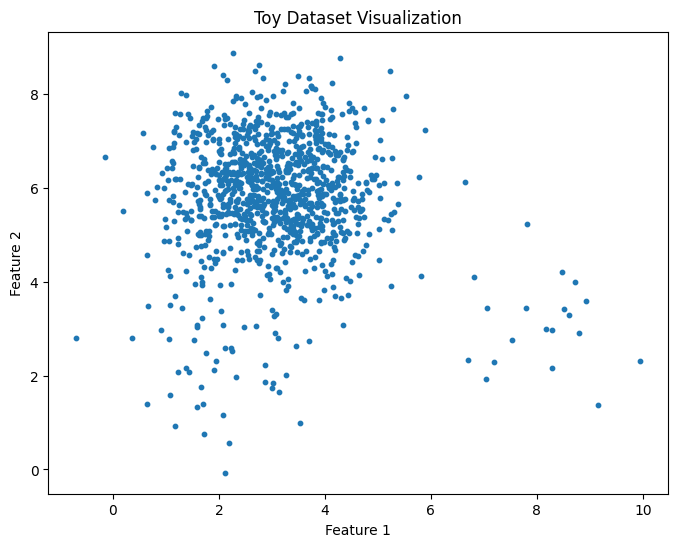

In [102]:
dataset2 = generate_dataset2()
visualize_dataset(dataset2, ordNumberOfAssignment=2)

### Task 2.2.
- Use Numpy only to implement the K-means method for finding three clusters from the toy dataset.
- Train this K-means with EM method.

In [103]:
def implement_kMeans_assignment02(dataset: list[list[float]], numberOfClusters: int = 3, max_iterations: int = 100) -> dict:
    '''
    Implements the K-Means clustering algorithm.

    Args:
        dataset (list[list[float]]): A list of data points, where each data point is a list of floats.
        numberOfClusters (int): The desired number of clusters (k).
        max_iterations (int): The maximum number of iterations to run the algorithm.

    Returns:
        dict: A dictionary where keys are cluster IDs (integers) and values are
              dictionaries containing:
              - 'centroid': The final centroid of the cluster (list of floats).
              - 'points': A list of data points assigned to that cluster.
    '''

    # Step 1: Initialize centroids randomly
    # Select 'numberOfClusters' random data points from the dataset as initial centroids.
    # It's good practice to ensure unique initial centroids.
    initial_centroid_indices = random.sample(range(len(dataset)), numberOfClusters)
    
    clusters = {}
    for i, idx in enumerate(initial_centroid_indices):
        clusters[i] = {
            'centroid': list(dataset[idx]),  # Make a copy to avoid modifying original dataset
            'points': []
        }

    # Iterate until convergence or max_iterations
    for iteration in range(max_iterations):
        # Step 2: Assignment Step - Assign each data point to the nearest cluster
        # Create a new structure for the current iteration's assignments
        new_clusters_points = {i: [] for i in range(numberOfClusters)}
        
        for datapoint in dataset:
            cluster_id = find_nearestCluster(datapoint, clusters)
            new_clusters_points[cluster_id].append(datapoint)
        
        # Step 3: Update Step - Recalculate centroids
        old_centroids = {k: list(v['centroid']) for k, v in clusters.items()} # Copy old centroids
        
        for cluster_id, points_in_cluster in new_clusters_points.items():
            if points_in_cluster:  # Only update if the cluster has points
                new_centroid = update_latestCentroid(points_in_cluster)
                clusters[cluster_id]['centroid'] = new_centroid
            else:
                # Handle empty cluster: you might reinitialize its centroid
                # or keep the old one. For now, we'll just keep the old one
                # if the cluster becomes empty, as a simple approach.
                pass 
                
        # Update the points in the main clusters dictionary
        for cluster_id, points_in_cluster in new_clusters_points.items():
            clusters[cluster_id]['points'] = points_in_cluster

        # Check for convergence: if centroids don't change significantly
        converged = True
        for cluster_id, old_centroid in old_centroids.items():
            if calculate_distance(old_centroid, clusters[cluster_id]['centroid']) > 1e-6: # Small threshold for float comparison
                converged = False
                break
        
        if converged:
            print(f"K-Means converged after {iteration + 1} iterations.")
            break
    else:
        print(f"K-Means reached maximum iterations ({max_iterations}) without converging.")

    return clusters

In [107]:
cluster2 = implement_kMeans_assignment02(dataset=dataset2, numberOfClusters=5, max_iterations=100)
cluster2

K-Means converged after 13 iterations.


{0: {'centroid': [np.float64(3.7656926734062233),
   np.float64(5.321955918813673)],
  'points': [array([4.33427301, 3.07372924]),
   array([4.30422705, 3.65984288]),
   array([6.64215542, 6.12097433]),
   array([5.36490943, 6.10471645]),
   array([3.65391252, 5.22145507]),
   array([4.70567176, 5.86153209]),
   array([3.44680036, 4.83873421]),
   array([3.12380958, 6.00316279]),
   array([3.87781483, 5.85821052]),
   array([4.1491461 , 3.89154989]),
   array([3.93710238, 5.18785869]),
   array([3.89293252, 5.86449879]),
   array([3.48045148, 5.4490067 ]),
   array([3.12916258, 5.83423554]),
   array([3.33919466, 5.05210996]),
   array([4.62704038, 5.23365809]),
   array([3.41375096, 4.83900588]),
   array([2.71567932, 4.82854376]),
   array([3.02203063, 5.48323468]),
   array([4.93120772, 6.20100005]),
   array([3.81232202, 4.51940143]),
   array([4.05795577, 6.06466709]),
   array([3.56861856, 5.91173435]),
   array([3.02683015, 5.2205848 ]),
   array([4.86399629, 6.27348833]),
   ar

C:\Users\VICTUS\AppData\Local\Temp\ipykernel_1740\2954007180.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(clusters))  # Get distinct colors


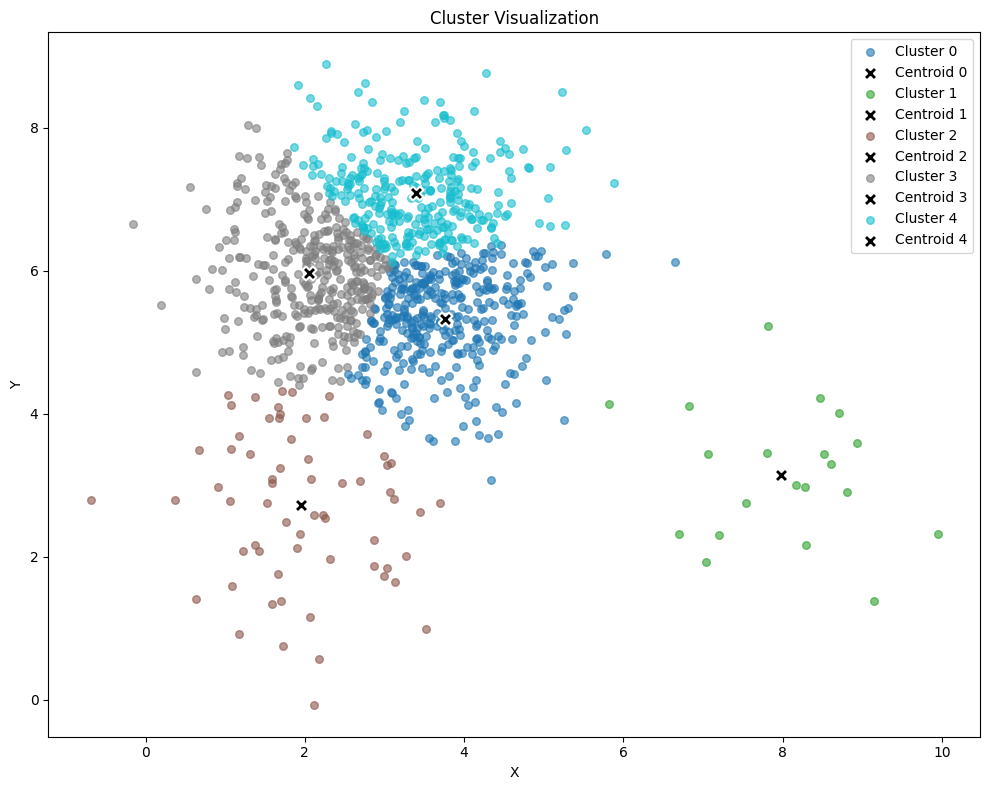

In [108]:
visualize_clusters(clusters=cluster2, ordNumberOfAssignment=2)